# Recognition

In [2]:
import os
from tqdm.autonotebook import tqdm, trange
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
import numpy as np
import torchvision

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

C:\Users\dnrpc\AppData\Local\Temp/ipykernel_14476/2290000902.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Data upload

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './tank_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

In [6]:
print(dataset_sizes)

{'train': 350, 'val': 64}


Images in a training batch

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

###### Training a model

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(dataloaders[phase],
                             leave=False,
                             desc=f"{phase} iter:"):

                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                if phase == "train":
                    optimizer.zero_grad()

                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses

###### Visualizing the model 

In [22]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

###### Valid accuracy test

In [23]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [24]:
from PIL import Image
validation_img_paths = ["/val/m1abrams/fda.jpg",
                 "/val/m1abrams/inetfs8atqg41.jpg", 
                 "/val/m1abrams/gettyimages-1677830-612x612.jpg",
                 "/val/m1abrams/gettyimages-635214138-612x612.jpg",
                 "/val/t90/ajdljalfj.jpg",
                 "/val/t90/t90tank.jpg",
                 "/val/t90/istockphoto-517500685-612x612.jpg",
                 "/val/t90/gettyimages-976534602-612x612.jpg"]
img_list = [Image.open(data_dir + img_path) for img_path in validation_img_paths]
validation_batch = torch.stack([data_transforms['val'](img).cuda()
                                for img in img_list])

## CNN without transfer learning

In [25]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(244),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [26]:
# Очень простая сеть
class SimpleCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96), nn.ReLU(), nn.MaxPool2d(kernel_size=2))

        self.out = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                 nn.Linear(96 * 5 * 5, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [27]:
cnnmodel=SimpleCnn()

In [28]:
# Использовать ли GPU
if use_gpu:
    cnnmodel = cnnmodel.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(cnnmodel.parameters(), lr=1e-3)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
cnnmodel, losses = train_model(cnnmodel, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

Training complete in 3m 54s
Best val Acc: 0.781250


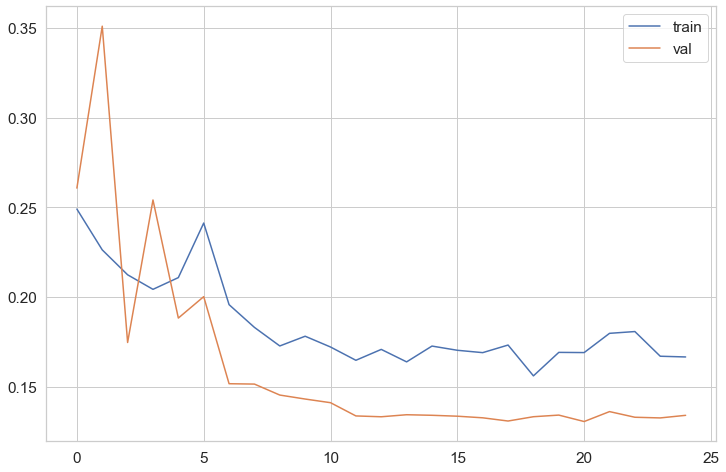

In [30]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [31]:
print("Accuracy: {0:.4f}".format(evaluate(cnnmodel)))

Accuracy: 0.7812


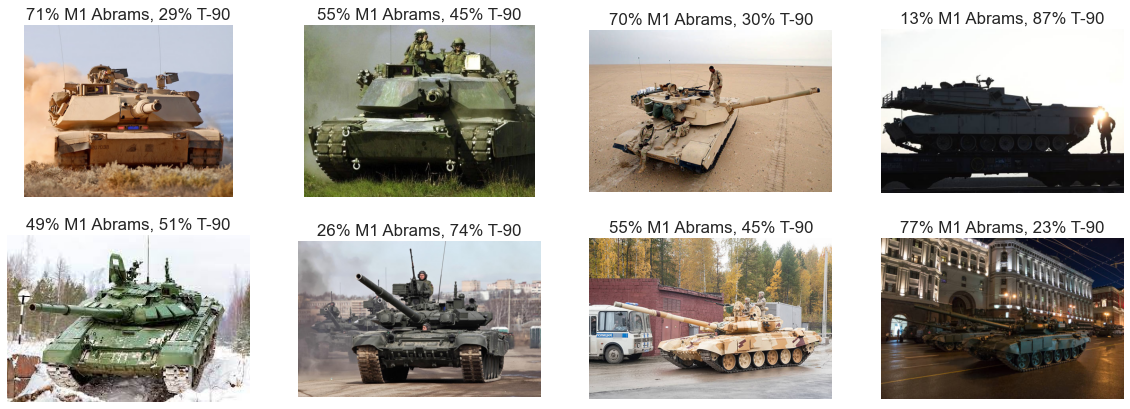

In [32]:
pred_logits_tensor = cnnmodel(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
fig, axs = plt.subplots(2, len(img_list)//2, figsize=(20, 7))
for i, img in enumerate(img_list):
    ax = axs[i//4,i%4]
    ax.axis('off')
    ax.set_title("{:.0f}% M1 Abrams, {:.0f}% T-90".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

## ALEXNET
The architecture of the net:
<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png">

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './tank_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

Model upload, with pretrained weigths

In [31]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

Training complete in 5m 34s
Best val Acc: 0.953125


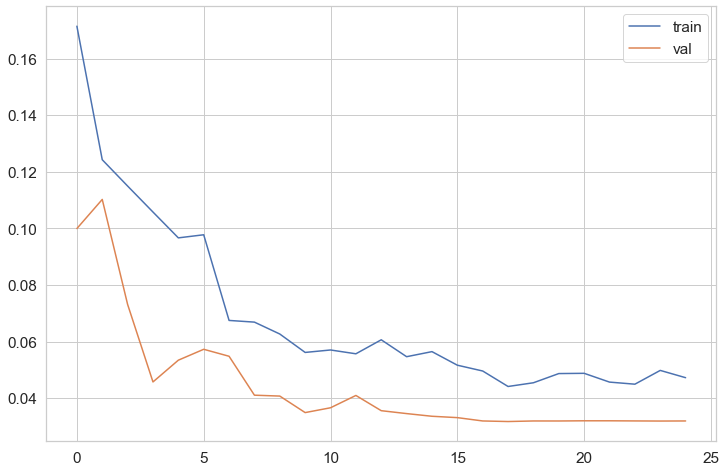

In [21]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [23]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [24]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9375


In [107]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 8.0224, -6.0637],
        [ 2.1432, -1.3365],
        [ 1.4688, -1.0351],
        [ 0.9119, -1.0943],
        [-3.6196,  3.2568],
        [-6.2566,  5.9218],
        [-1.9345,  1.7709],
        [-1.8750,  1.3214]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [108]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.99999285e-01, 7.62957768e-07],
       [9.70102668e-01, 2.98973117e-02],
       [9.24419940e-01, 7.55800605e-02],
       [8.81444275e-01, 1.18555695e-01],
       [1.03079528e-03, 9.98969197e-01],
       [5.13982786e-06, 9.99994874e-01],
       [2.40007415e-02, 9.75999236e-01],
       [3.93037833e-02, 9.60696220e-01]], dtype=float32)

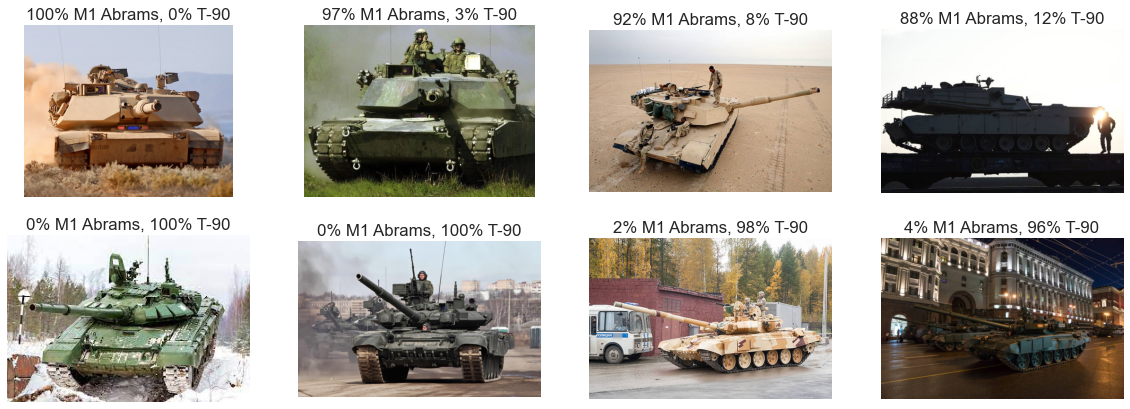

In [109]:
fig, axs = plt.subplots(2, len(img_list)//2, figsize=(20, 7))
for i, img in enumerate(img_list):
    ax = axs[i//4,i%4]
    ax.axis('off')
    ax.set_title("{:.0f}% M1 Abrams, {:.0f}% T-90".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

## Inception_v3
The architecture of the net:
<img src="https://cdn-images-1.medium.com/max/1040/1*uW81y16b-ptBDV8SIT1beQ.png">


In [26]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [37]:
model_extractor = models.inception_v3(pretrained=True)

In [28]:
model_extractor.AuxLogits.fc = nn.Linear(768, 2)
model_extractor.fc = nn.Linear(2048, 2)

In [35]:
# # num_features -- это размерность вектора фич, поступающего на вход FC-слою
# num_features = 25088
# # Заменяем Fully-Connected слой на наш линейный классификатор
# model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

train iter::   0%|          | 0/88 [00:00<?, ?it/s]

val iter::   0%|          | 0/16 [00:00<?, ?it/s]

Training complete in 18m 30s
Best val Acc: 1.000000
Wall time: 18min 30s


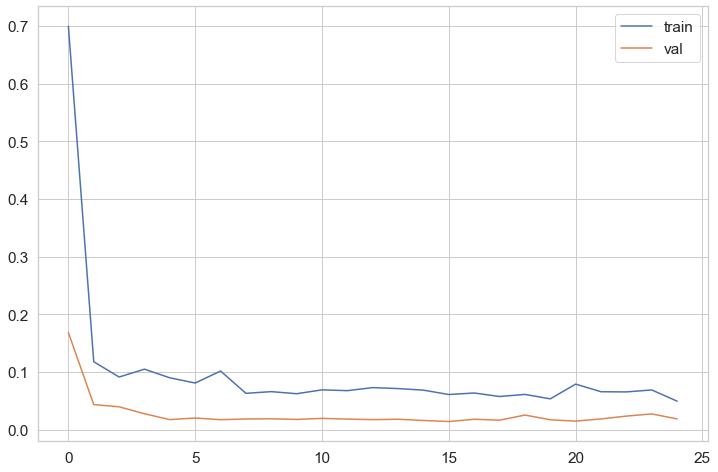

In [34]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [31]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

In [32]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

<All keys matched successfully>

In [33]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9688


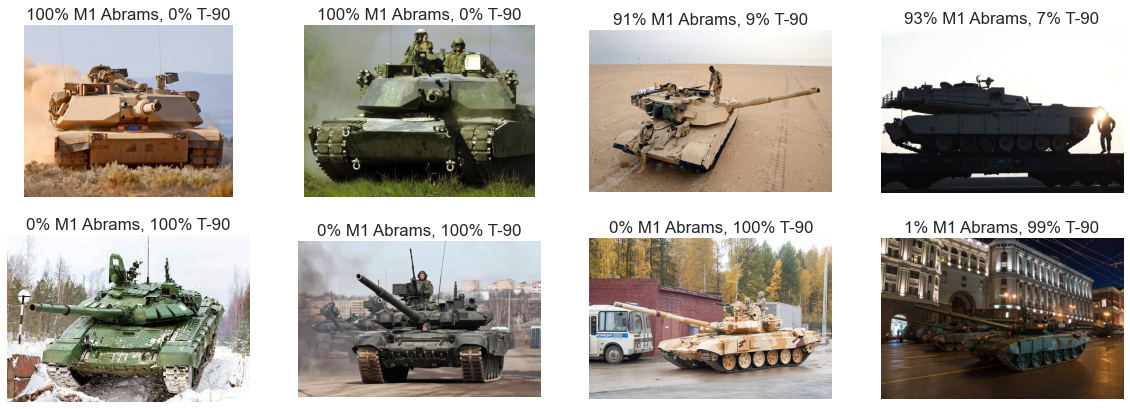

In [110]:
pred_logits_tensor = model_extractor(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
fig, axs = plt.subplots(2, len(img_list)//2, figsize=(20, 7))
for i, img in enumerate(img_list):
    ax = axs[i//4,i%4]
    ax.axis('off')
    ax.set_title("{:.0f}% M1 Abrams, {:.0f}% T-90".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)